In [138]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline

Fossil fuels

Using the formula in Eq.4 and the plant values from the Excel (Table 2) calculate the EROEI_el for all CFs between 50 and 90. Then create a conversion factor.

In [139]:
CFs=[50,55,60,65,70,75,80,85,90]
EROEI_els=[[8.8,9.2,8.8,10.7,11,26],
[9.2,9.6,9.2,11.2,11.5,27],
[9.6,10.1,9.7,11.6,12,27.8],
[10,10.5,10.1,12,12.4,28.6],
[10.3,10.8,10.5,12.4,12.8,29.3],
[10.7,11.1,10.8,12.7,13.2,29.9],
[11,11.5,11.2,13,13.5,30.5],
[11.2,11.7,11.5,13.3,13.8,31],
[11.5,12,11.8,13.5,14.1,31.5]]

In [140]:
df=pd.DataFrame(EROEI_els).T
df.columns=CFs
df.index.name='Plant #'
df.columns.name='CF'

In [141]:
df

CF,50,55,60,65,70,75,80,85,90
Plant #,,,,,,,,,
0,8.8,9.2,9.6,10.0,10.3,10.7,11.0,11.2,11.5
1,9.2,9.6,10.1,10.5,10.8,11.1,11.5,11.7,12.0
2,8.8,9.2,9.7,10.1,10.5,10.8,11.2,11.5,11.8
3,10.7,11.2,11.6,12.0,12.4,12.7,13.0,13.3,13.5
4,11.0,11.5,12.0,12.4,12.8,13.2,13.5,13.8,14.1
5,26.0,27.0,27.8,28.6,29.3,29.9,30.5,31.0,31.5


Capacity factor conversion ratio

In [142]:
(df[90]/df[50])/(90/50.0)

Plant #
0    0.726010
1    0.724638
2    0.744949
3    0.700935
4    0.712121
5    0.673077
dtype: float64

When we step up from CF 50 to 90, EROEI_el only gets to 70% of what it should be using pure capacity factor conversion (90/50=1.8 multiplier). This is of course still dependent on the source EROEI, but let us use 0.7 for now, judgin on the examined EROEI ranges and the resultant conversion ratio values from the table above.

In [143]:
CF=[50,90]
CF_ratio=[1,0.7]

We need to create a similar ratio for the Capture ratio CR. We use the Energy penalty figure from the Data from GOTO Excel file, sheet title Efficiency v.s capture rate.

|CR | energy penalty  |
|--|--|
|50| 16  |
|90| 28|

In [144]:
CR=[90,50]
CR_ratio=[1, 16.0/28]

In [145]:
CR_ratio

[1, 0.5714285714285714]

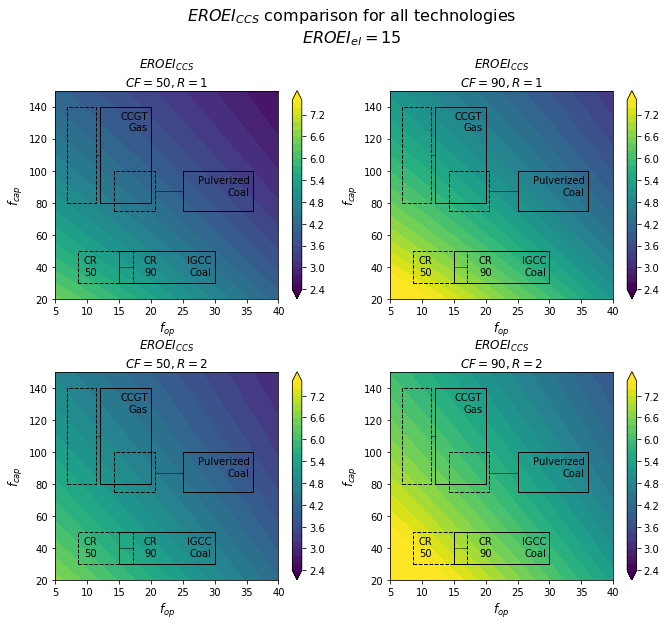

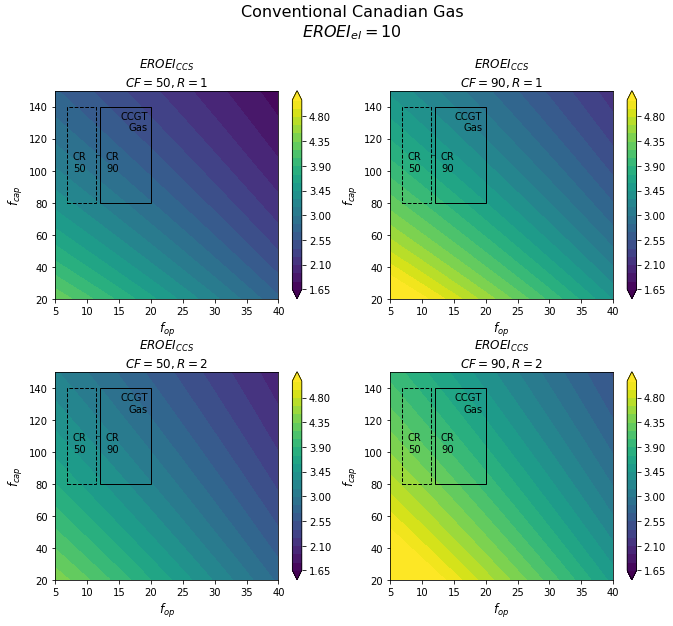

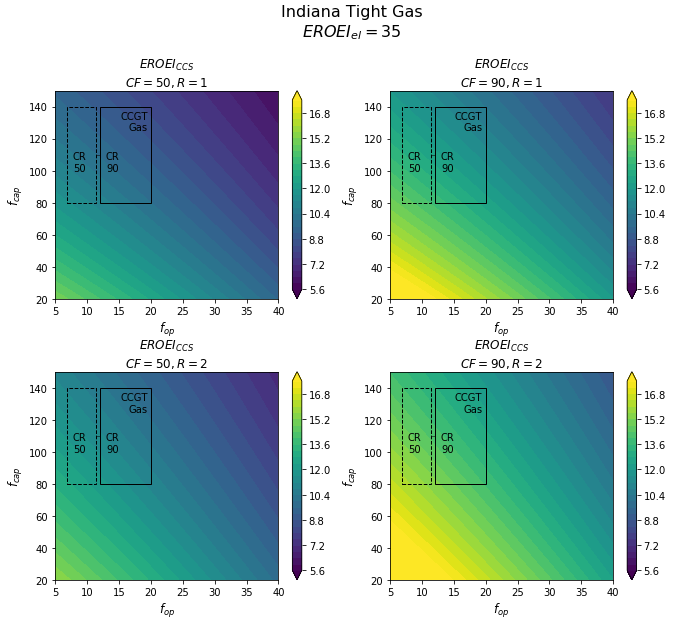

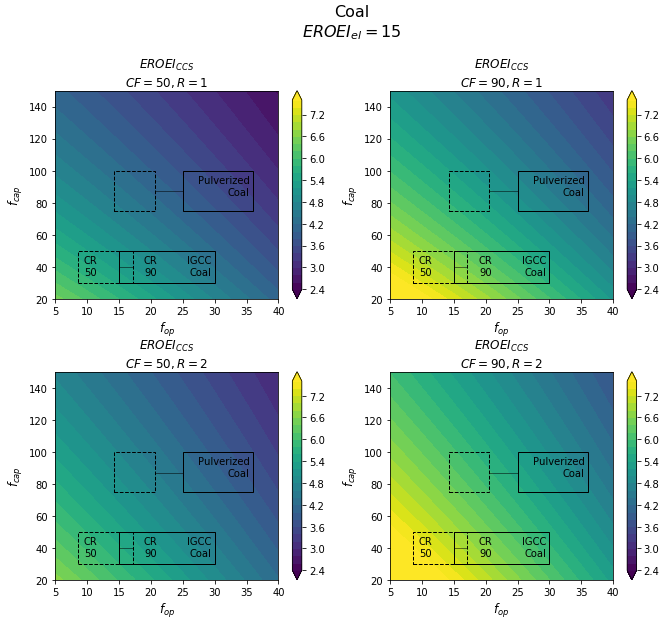

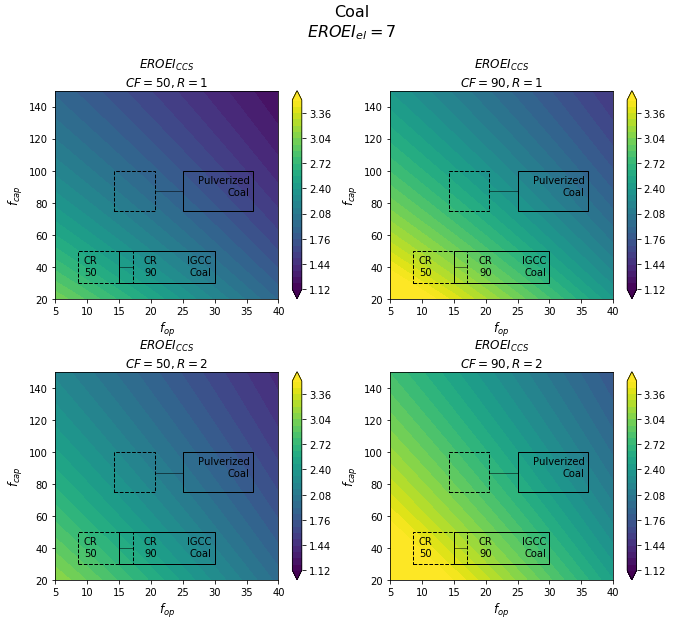

In [163]:
fop=np.linspace(5,40,100)
fcap=np.linspace(20,150,100)
R=[1,2]
titles=[u'$EROEI_{CCS}$ comparison for all technologies','Conventional Canadian Gas','Indiana Tight Gas','Coal','Coal']
eroei_els=[15,10,35,15,7]
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
t0s=[[12,20,80,140],[25,36,75,100],[15,30,30,50]]                
minmax=[{'min':0,'max':0} for i in range(4)]
for r in range(len(titles)):
    eroei_el=eroei_els[r]
    eroei_ccs=np.zeros([len(CR),len(CF),len(fop),len(fcap)])
    for i in range(len(R)):
        for j in range(len(CF)):
            for k in range(len(fop)):
                for l in range(len(fcap)):
                    eroei_ccs[i][j][l,k]=(1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0
                    if ((i==1)and(j==1)):
                        if r==1:
                            n=0
                            p=0
                        elif r==2:
                            n=0
                            p=1
                        elif r==3:
                            n=2
                            p=2
                        elif r==4:
                            n=2
                            p=3
                        if ((abs(fop[k]-t0s[n][0])<0.5)and(abs(fcap[l]-t0s[n][2])<1.5)):
                            minmax[p]['max']=eroei_ccs[i][j][l,k]
                        if ((abs(fop[k]-t0s[n][1])<0.5)and(abs(fcap[l]-t0s[n][3])<1.5)):
                            minmax[p]['min']=eroei_ccs[i][j][l,k]

    fig,axes=plt.subplots(2,2,figsize=(11,9))
    plt.subplots_adjust(hspace=0.35)
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            ax=axes[i][j]
            z = eroei_ccs[i][j]
            levels = MaxNLocator(nbins=30).tick_values(eroei_el/6.0, eroei_el/2.0)
            cmap = plt.get_cmap('viridis')
            X, Y = np.meshgrid(fop, fcap)
            im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
            fig.colorbar(im, ax=ax)
            ax.set_xlim((fop.min(),fop.max()))
            ax.set_ylim((fcap.min(),fcap.max()))
            
            ls=['-','--']
            ls0='-'
            lw0=0.5
            for m in range(len(CR_ratio)):
                n=m*0
                for ti in range(len(t0s)):
                    if ((r==0)or(((r==1)or(r==2))and(ti==0))or(((r==3)or(r==4))and(ti!=0))):
                        t0=t0s[ti]
                        t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                        rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],linewidth=1,edgecolor='k',facecolor='none',ls=ls[m])
                        ax.add_patch(rect)
                        if ti==2:
                            ax.text(t[0]+2+(1-m)*3,t[3]-15,'CR\n'+str(CR[m]),horizontalalignment='center')
                        elif ti==0:
                            if ((r==1)or(r==2)):
                                ax.text(t[0]+2,t[3]-40,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if m==0: 
                            ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right')
                        else:
                            line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',linewidth=lw0,ls=ls0)
                            ax.add_line(line)  

            ax.set_xlabel('$f_{op}$',fontsize=12)
            ax.set_ylabel('$f_{cap}$',fontsize=12)
            ax.set_title(u'$EROEI_{CCS}$\n$CF='+str(CF[j])+', R='+str(R[i])+'$')
    plt.suptitle(titles[r]+'\n'+r'$EROEI_{el}='+str(eroei_el)+'$',fontsize=16,y=1.01)
    plt.show()

RE

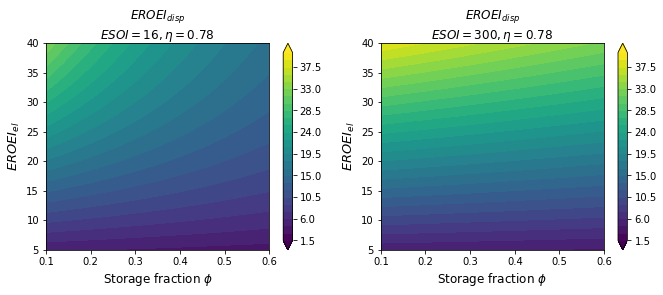

In [147]:
eroei_el=np.linspace(5,40,100)
phi=np.linspace(.10,.60,100)
ESOI=[16,300]
eta=0.78
eroei_disp=np.zeros([len(ESOI),len(phi),len(eroei_el)])
for i in range(len(ESOI)):
    for j in range(len(phi)):
        for k in range(len(eroei_el)):
            eroei_disp[i][k,j]=((1-phi[j])+(eta*phi[j]))/((1/eroei_el[k])+(eta*phi[j]/ESOI[i]))
fig,axes=plt.subplots(1,2,figsize=(11,3.8))
plt.subplots_adjust(hspace=0.35)
#levels = MaxNLocator(nbins=15).tick_values(4000, 15000)
for i in range(len(axes)):
    ax=axes[i]
    z = eroei_disp[i]
    levels = MaxNLocator(nbins=30).tick_values(2, 40)
    cmap = plt.get_cmap('viridis')
    X, Y = np.meshgrid(phi, eroei_el)
    im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')

    fig.colorbar(im, ax=ax)
    ax.set_xlim((phi.min(),phi.max()))
    ax.set_ylim((eroei_el.min(),eroei_el.max()))

    ax.set_xlabel('Storage fraction $\phi$',fontsize=12)
    ax.set_ylabel('$EROEI_{el}$',fontsize=13)
    ax.set_title(u'$EROEI_{disp}$\n$ESOI='+str(ESOI[i])+', \eta='+str(eta)+'$')
plt.show()

Overlay

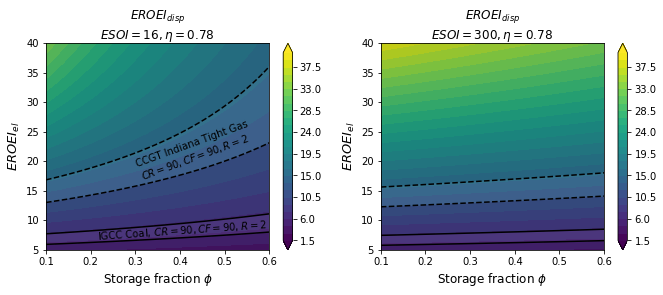

In [203]:
eroei_el=np.linspace(5,40,100)
phi=np.linspace(.10,.60,100)
ESOI=[16,300]
eta=0.78
eroei_disp=np.zeros([len(ESOI),len(phi),len(eroei_el)])
for i in range(len(ESOI)):
    for j in range(len(phi)):
        for k in range(len(eroei_el)):
            eroei_disp[i][k,j]=((1-phi[j])+(eta*phi[j]))/((1/eroei_el[k])+(eta*phi[j]/ESOI[i]))
fig,axes=plt.subplots(1,2,figsize=(11,3.8))
plt.subplots_adjust(hspace=0.35)
#levels = MaxNLocator(nbins=15).tick_values(4000, 15000)
for i in range(len(axes)):
    ax=axes[i]
    z = eroei_disp[i]
    levels = MaxNLocator(nbins=30).tick_values(2, 40)
    cmap = plt.get_cmap('viridis')
    X, Y = np.meshgrid(phi, eroei_el)
    im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
    fig.colorbar(im, ax=ax)
    
    r=2
    im = ax.contour(X, Y, z, levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',colors='k',linewidths=1.5)
    im = ax.contourf(X, Y, z, colors=[[0,0,0,1],[1,1,1,1],[0,0,0,1]], levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',alpha=0.05,)
    r=1
    im = ax.contour(X, Y, z, levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',colors='k',linewidths=1.5,linestyles='--')
    im = ax.contourf(X, Y, z, colors=[[0,0,0,1],[1,1,1,1],[0,0,0,1]], levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',alpha=0.05,)
    
    ax.set_xlim((phi.min(),phi.max()))
    ax.set_ylim((eroei_el.min(),eroei_el.max()))

    ax.set_xlabel('Storage fraction $\phi$',fontsize=12)
    ax.set_ylabel('$EROEI_{el}$',fontsize=13)
    ax.set_title(u'$EROEI_{disp}$\n$ESOI='+str(ESOI[i])+', \eta='+str(eta)+'$')

axes[0].text(0.3,23.3,'CCGT Indiana Tight Gas\n$CR=90,CF=90,R=2$',rotation=20)
axes[0].text(0.215,8.7,'IGCC Coal, $CR=90,CF=90,R=2$',rotation=4)

plt.show()

CF plot

In [13]:
df=pd.read_excel('cfdata.xlsx')

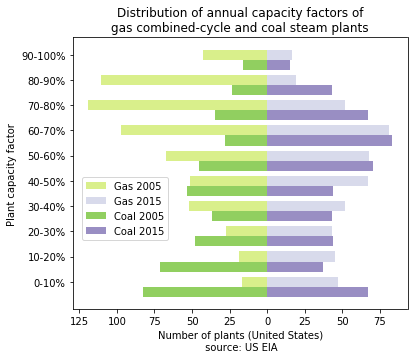

In [109]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,df['PC 2005'],0.4,color='#d9ef8b',label='Gas 2005')
ax.barh(df.index,df['PC 2015'],0.4,color='#d8daeb',label='Gas 2015')
ax.barh(df.index-0.4,df['NG 2005'],0.4,color='#91cf60',label='Coal 2005')
ax.barh(df.index-0.4,df['NG 2015'],0.4,color='#998ec3',label='Coal 2015')
fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[1:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.3, 0.37))
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Number of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.show()